In [1]:
import scipy.stats
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import statsmodels.formula.api as smf

In [2]:
# Read in csv file and print out the number of rows
df = pd.read_csv('GPTarget2024.csv')

# Filter out all rows that are not in the microtargeting treatment condition
df = df[df['treatment_condition'] == 'microtargeting']

# Create new dataframes split by issue
df_digital_privacy = df[df['issue_stance'] == "The U.S. should not implement legislation that strengthens digital privacy rights"]
df_renewable_energy = df[df['issue_stance'] == "The U.S. should increase investments in renewable energy technologies."]
df_china_sanctions = df[df['issue_stance'] == "The U.S. should impose stronger economic sanctions on China."]
df_nato_support = df[df['issue_stance'] == "The U.S. should not increase its support for NATO."]

In [3]:
#hypothesis 2, model 1

# Define the formula for the model
formula = 'dv_response_mean ~ number_attributes_targeted + political_party_coded + political_ideology_coded + political_engagement_coded'

# Fit the model for all issues 
model = smf.ols(formula, data=df)
result = model.fit(cov_type='HC3')

# Fit the model for digital privacy
model_digital_privacy = smf.ols(formula, data=df_digital_privacy)
result_digital_privacy = model_digital_privacy.fit(cov_type='HC3')

# Fit the model for renewable energy
model_renewable_energy = smf.ols(formula, data=df_renewable_energy)
result_renewable_energy = model_renewable_energy.fit(cov_type='HC3')

# Fit the model for china sanctions
model_china_sanctions = smf.ols(formula, data=df_china_sanctions)
result_china_sanctions = model_china_sanctions.fit(cov_type='HC3')

# Fit the model for nato support
model_nato_support = smf.ols(formula, data=df_nato_support)
result_nato_support = model_nato_support.fit(cov_type='HC3')

# Print the summary of the regression
print(result_china_sanctions.summary())

                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.872
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           4.49e-07
Time:                        09:40:20   Log-Likelihood:                -6432.5
No. Observations:                1403   AIC:                         1.287e+04
Df Residuals:                    1398   BIC:                         1.290e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [4]:
# Create a dataframe to store the results for plotting
issues_models = {
    'Renewable Energy': result_renewable_energy,
    'Digital Privacy': result_digital_privacy,
    'China Sanctions': result_china_sanctions,
    'NATO Support': result_nato_support
}

# Initialize an empty list to store the data
data = []

# Iterate over the dictionary to extract the data
for issue, model in issues_models.items():
    # Extract the coefficients and the confidence intervals
    coef = model.params
    conf_int = model.conf_int()
    
    # Iterate over the coefficients
    for covariate in ['number_attributes_targeted']:
        # Use the Q function label format
        q_covariate = f'{covariate}'
        # Skip if the covariate is not in the model
        if q_covariate not in coef:
            continue
        # Get the coefficient and confidence interval
        coefficient = coef[q_covariate]
        lower_ci, upper_ci = conf_int.loc[q_covariate]
        
        # Append the data to the list
        data.append({
            'Covariate': covariate,
            'Issue': issue,
            'Coefficient': coefficient,
            '95% CI Lower': lower_ci,
            '95% CI Upper': upper_ci
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(data)

In [5]:
# Compute and append precision-weighted means and confidence intervals to the results DataFrame
models = [result_renewable_energy, result_digital_privacy, result_china_sanctions, result_nato_support]

def compute_weighted_stats(term, models):
    coefficients = np.array([model.params[term] for model in models])
    standard_errors = np.array([model.bse[term] for model in models])

    weights = 1 / standard_errors**2
    weighted_mean = np.sum(coefficients * weights) / np.sum(weights)
    weighted_variance = 1 / np.sum(weights)
    weighted_std_error = np.sqrt(weighted_variance)

    z_critical = scipy.stats.norm.ppf(0.975)  # 97.5th percentile for two-tailed test
    confidence_interval = (weighted_mean - z_critical * weighted_std_error, 
                           weighted_mean + z_critical * weighted_std_error)

    return weighted_mean, weighted_std_error, confidence_interval

# Compute for "microtargeting" and "false microtargeting" and "no microtargeting"
attributes_mean, attributes_se, attributes_ci = compute_weighted_stats('number_attributes_targeted', models)
z_score = attributes_mean / attributes_se
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print(f'P-value for the precision-weighted mean: {p_value}')

# Create a list of dictionaries for the new rows including the standard error
weighted_stats = [
    {'Covariate': 'number_attributes_targeted', 'Issue': 'Precision-weighted Mean', 'Coefficient': attributes_mean, 'SE': attributes_se, '95% CI Lower': attributes_ci[0], '95% CI Upper': attributes_ci[1]},
]

# Convert the list of dictionaries to a DataFrame
weighted_stats_df = pd.DataFrame(weighted_stats)

# Append the new DataFrame to the existing results_df
results_df = results_df.append(weighted_stats_df, ignore_index=True)

P-value for the precision-weighted mean: 0.2012281605633761


/var/folders/t7/fh798gkn2n7frwp_k082lvj80000gn/T/ipykernel_91304/3605401900.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(weighted_stats_df, ignore_index=True)


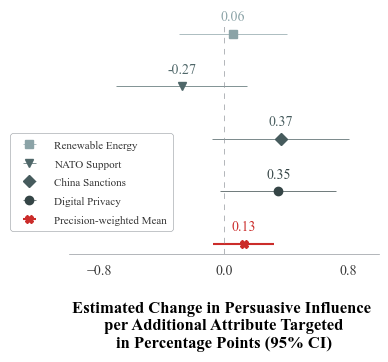

In [6]:
#FIGURE 2

# Set the font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Define constants
TITLES = ["Precision-weighted Mean", "Digital Privacy", "China Sanctions", "NATO Support", "Renewable Energy"]
COLOR_MAP = ['#CB2C2A', '#354546', '#465B5D', '#4F6769', '#8BA3A7']
MARKERS = ['X', 'o', 'D', 'v', 's']

# Set the plot dimensions
fig, ax = plt.subplots(figsize=(4,3))

# Use floating point numbers for the y_pos array
y_pos = np.arange(len(TITLES), dtype=float) - len(TITLES)/2 * 0.1

for i, (title, color, marker) in enumerate(zip(TITLES, COLOR_MAP, MARKERS)):
    # Filter the results_df for the current issue
    df_issue = results_df[results_df['Issue'] == title]
    
    # Extract coefficients and confidence intervals
    coef = df_issue['Coefficient'].values[0]
    lower_ci = df_issue['95% CI Lower'].values[0]
    upper_ci = df_issue['95% CI Upper'].values[0]
    
    # Plot coefficients with error bars and add coefficient labels
    linewidth = None if title == 'Precision-weighted Mean' else 0.5
    ax.errorbar(coef, y_pos[i] + 0.05, 
                xerr=[[coef - lower_ci], [upper_ci - coef]], 
                fmt=marker, color=color, ecolor=color, capsize=0, label=title, lw=linewidth)
    
    ax.text(coef, y_pos[i] + .4, round(coef, 2), 
            va='center', ha='center', color=color, 
            bbox=dict(facecolor='white', edgecolor='none', pad=2.1))

    # Update y_pos for next plot
    y_pos += 0.1
    
# Configure the plot
plt.axvline(0, color='#94999E', linestyle='--', linewidth=0.5, dashes=(8, 8))
plt.xlim(-1, 1)

ax.set_xlabel('Estimated Change in Persuasive Influence \n per Additional Attribute Targeted \nin Percentage Points (95% CI)', fontsize=12, fontweight='bold', labelpad=17)
ax.set_yticks([])
ax.set_yticklabels([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#94999E')
ax.spines['bottom'].set_linewidth(0.5)
ax.tick_params(colors='#333333')
ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax.tick_params(left=False)
ax.tick_params(bottom=False)

# Configure the legend
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1], loc=(-.19, 0.1), edgecolor='#94999E')
legend.get_frame().set_linewidth(0.5)

for text in legend.get_texts():
    text.set_color('#333333')
    text.set_fontsize(8)

# Display the plot
plt.show()

# Save the figure as a PDF
fig.savefig('figure2.pdf', format='pdf', bbox_inches='tight')